In [1]:
%matplotlib inline



# t-test for selected samples at different periods of time



This two cases were spotted using the GaHMM-profile model of the CO2 variable of North East part of the building

In [2]:
from pymongo import MongoClient
from __future__ import print_function
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn import metrics 

import sys
sys.path.append('../../lib')
import rs_common_framework_v4 as rs

import pandas as pd
import datetime
import collections
import numpy as np
import math

from sklearn.decomposition import PCA, IncrementalPCA
from matplotlib import cm, pyplot as plt, style as st, gridspec as gd
from matplotlib.dates import YearLocator, MonthLocator
st.use('seaborn-colorblind')

import plotly.offline as py
import plotly.graph_objs as go  #important library for the plotly
#import cufflinks as cf
import pylab as pl
from IPython.display import display

py.init_notebook_mode(connected=False) # run at the start of every ipython notebook to use plotly.offline
from plotly import tools #to do subplots

from hmmlearn.hmm import GaussianHMM
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
print("\t Connected to Mongo DB")

collection_feature_selection = 'feature_selection'
collection_statistics_daily = 'statistics_daily'
seasons = ['summer', 'winter', 't_period_1', 't_period_2']
day_type = ['working_day', 'weekend', 'holiday']

# select tag name
tag_query = {'category': {'$in': ['CO2', 'Temperature', 'Heating', 'Humidity']}, 'orientation': {'$in': ['NE']}}
path_model = '../../HMM_models/Final_models/'
file_name = 'named_' 

db_name = "project_db"
connection = MongoClient('localhost')  # "192.168.6.132"
collection_metadata = connection[db_name]["metadata"]
collection_series = connection[db_name]["filtered_time_series"]
collection_original = connection[db_name]["original_time_series"]
collection_statistics_general = connection[db_name]["statistics_general"]

collection_statistics_daily = connection[db_name][collection_statistics_daily]
collection_feature_selection = connection[db_name][collection_feature_selection]

	 Connected to Mongo DB


In [4]:

tag_list = rs.get_tag_names(collection_metadata, tag_query)
tag_list += ['V044_room101_temp']
print('Read final models of:', tag_list )
pack = dict()
for tag in tag_list:
    path_open = path_model + file_name + tag + '.pkl'
    print("\tReading the HMM model: \n{0}".format(path_open)) 
    pack[tag] = joblib.load(path_open)
    n_comp = pack[tag]['model'].n_components
    n_features = pack[tag]['model'].n_features
    print("\tn_comp = {0}, n_features = {1}".format(n_comp,n_features))

Read final models of: ['V005_vent01_CO2', 'V074_tabs_warm_NO', 'V004_vent01_hum_out', 'V006_vent01_temp_out', 'V012_vent01_temp_in', 'V044_room101_temp']
	Reading the HMM model: 
../../HMM_models/Final_models/named_V005_vent01_CO2.pkl
	n_comp = 34, n_features = 24
	Reading the HMM model: 
../../HMM_models/Final_models/named_V074_tabs_warm_NO.pkl
	n_comp = 33, n_features = 24
	Reading the HMM model: 
../../HMM_models/Final_models/named_V004_vent01_hum_out.pkl
	n_comp = 36, n_features = 24
	Reading the HMM model: 
../../HMM_models/Final_models/named_V006_vent01_temp_out.pkl
	n_comp = 37, n_features = 24
	Reading the HMM model: 
../../HMM_models/Final_models/named_V012_vent01_temp_in.pkl
	n_comp = 36, n_features = 24
	Reading the HMM model: 
../../HMM_models/Final_models/named_V044_room101_temp.pkl
	n_comp = 33, n_features = 24


# Observe cases:

In [5]:
tag_list = ['V005_vent01_CO2', 'V006_vent01_temp_out', 'V012_vent01_temp_in', 'V004_vent01_hum_out', 'V074_tabs_warm_NO', 'V044_room101_temp']
id_case = 4 #8 cases can be selected
print('Here case #',id_case)
tag = tag_list[0] # 0-5 tags
ylim = None

Here case # 4


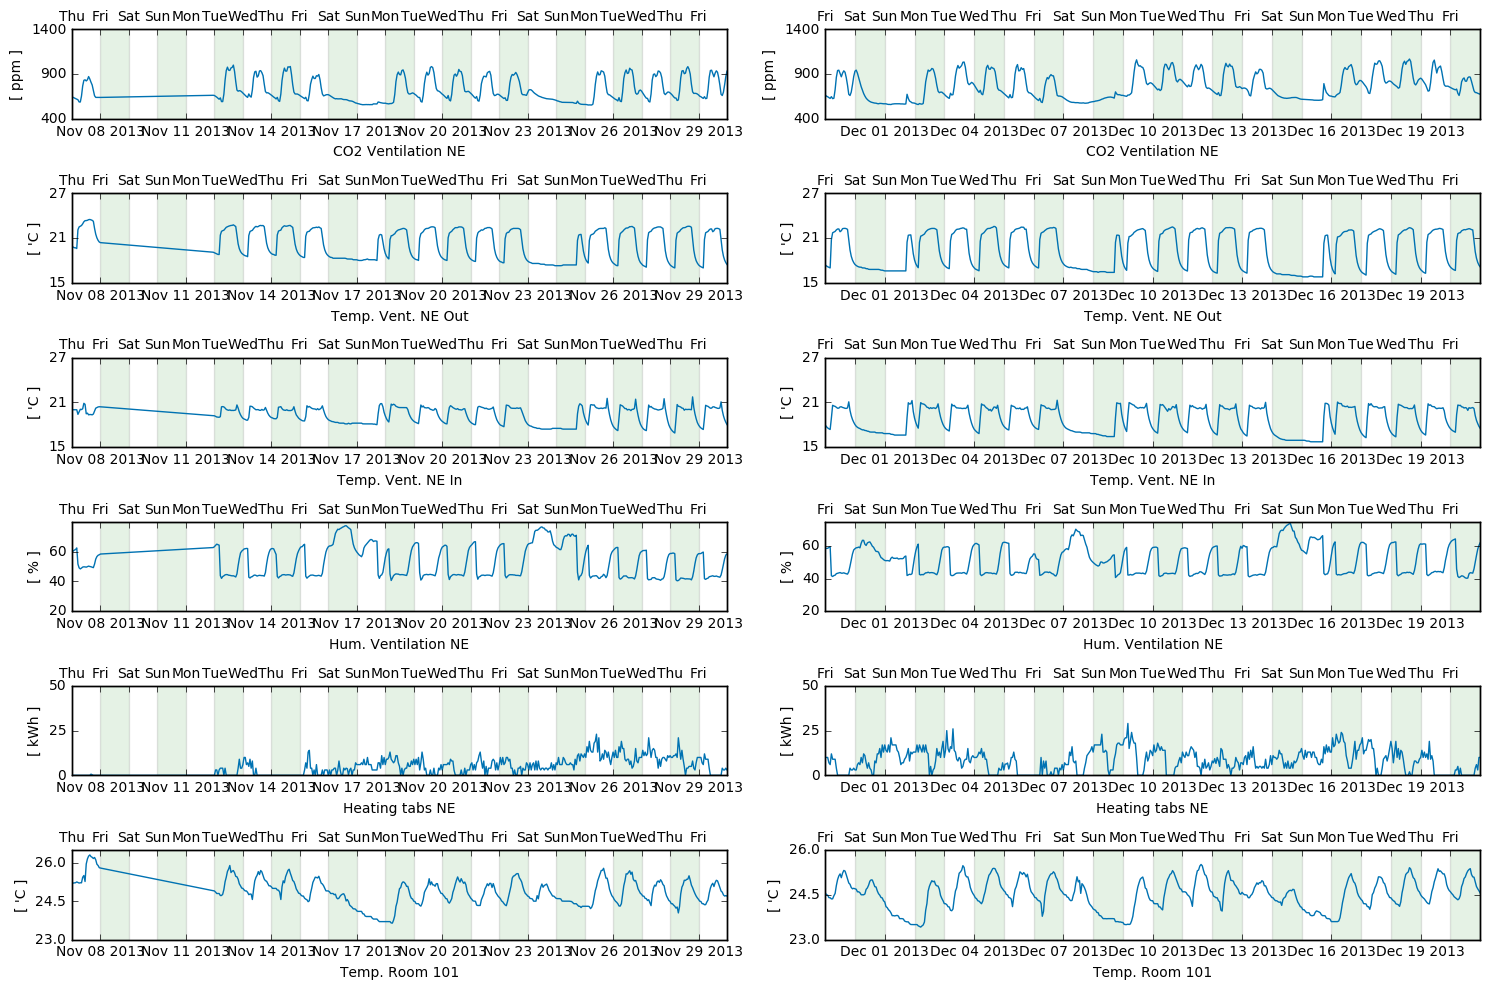

Temp. Room 101


In [6]:
n_rows = len(tag_list)
n_cols =2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,10))
#gs = gridspec.GridSpec(1, 2, width_ratios=[2, 2])

cases_normal ={
    2: ['2012-11-19','2012-12-03'],
    1: ['2012-10-15','2012-10-29'],
    4: ['2013-11-07','2013-11-30'],
    3: ['2013-01-28','2013-02-11'],
    5: ['2014-01-27','2014-02-10'],
    6: ['2014-11-03','2014-11-17'],
    7: ['2015-01-26','2015-02-09']
}



cases_fault ={
    2: ['2012-12-03','2012-12-17'],
    1: ['2012-10-29','2012-11-12'],
    4: ['2013-11-29', '2013-12-21'],
    3: ['2013-02-11','2013-02-25'],
    5: ['2014-02-10','2014-02-24'],
    6: ['2014-11-17','2014-12-01'],
    7: ['2015-02-09','2015-02-23'],
}


y_lim_dict = {
    tag_list[0]: [400,1400],
    tag_list[4]: [0,50],
    tag_list[3]: [20,60],
    tag_list[2]: [15,27],
    tag_list[1]: [15,27],
    tag_list[5]: [23,26]
}

lol, upl = rs.get_lol_upl(collection_statistics_general, tag)
dv = (upl - lol) * 0.3
if ylim is None:
    ylim = y_lim_dict[tag]
    #ylim = [lol-dv, upl+1.2*dv]
    
n_tick = 3
siz = max(int((ylim[-1]-ylim[0])/n_tick),1)
y_tick = np.linspace(ylim[0], ylim[-1], siz)
#print(y_tick)
#print(ylim)
# Normal period 
start_time, end_time  = cases_normal[id_case][0], cases_normal[id_case][1]
# Fault period 
start_fault, end_fault =  cases_fault[id_case][0], cases_fault[id_case][1]
i,j =0,0
for tag in tag_list:
    
    if j>n_cols-1:
        i,j = i+1, 0
        
    alias =  rs.get_alias(collection_metadata, tag)
    ax = axes[i][j]    
    rs.plot_trend_with_fringes(ax, start_time, end_time, collection_original, tag, y_lim=y_lim_dict[tag], 
                               n_tick=n_tick, collection_metadata=collection_metadata)
    
    #ax.set_xlabel('Two weeks before the fault period')
    ax.set_xlabel(alias)
    j+=1
    ax = axes[i][j] 
    rs.plot_trend_with_fringes(ax, start_fault, end_fault, collection_original, tag, y_lim=y_lim_dict[tag],
                               n_tick=n_tick, collection_metadata=collection_metadata)

    j+=1
    #ax.set_xlabel('Fault period')
    ax.set_xlabel(alias)

plt.tight_layout()

plt.show()
alias = rs.get_alias(collection_metadata, tag)
print(alias)

In [7]:
print('Get timeline, seasonal information and regimen of interaction')
time_query = {}
timeline = rs.get_timeline(collection_statistics_daily, time_query, freq='1D')
start_time = timeline[0]
end_time = timeline[-1]

filter_query = {'tagname': tag}
projection = ['seasonal_label', 'weekday_name', 'day_type', 'interaction_NE']
df = rs.get_tag_values(collection_statistics_daily,time_query,projection,series_format='DF_t')

print('We include ID candidates for each date, that is: ',tag_list)
for tag in tag_list:    
    df_vect = rs.get_samples(collection_series, start_time, end_time, tag,normalization=False)
    X = df_vect.values
    model = pack[tag]['model']
    df[tag] = model.predict(X) 
    
df.head(2)

Get timeline, seasonal information and regimen of interaction
We include ID candidates for each date, that is:  ['V005_vent01_CO2', 'V006_vent01_temp_out', 'V012_vent01_temp_in', 'V004_vent01_hum_out', 'V074_tabs_warm_NO', 'V044_room101_temp']


day_type interaction_NE seasonal_label weekday_name  \
timestamp                                                        
2012-06-23  weekend      Regime PC         summer     Saturday   
2012-06-24  weekend      Regime WC         summer       Sunday   

            V005_vent01_CO2  V006_vent01_temp_out  V012_vent01_temp_in  \
timestamp                                                                
2012-06-23               21                    35                    2   
2012-06-24               21                     1                    2   

            V004_vent01_hum_out  V074_tabs_warm_NO  V044_room101_temp  
timestamp                                                              
2012-06-23                    0                 10                 26  
2012-06-24                   12                  1                 17

In [8]:
tag = tag_list[1]

print('Dates when the discords occurs for ', tag)
df_discords = pd.DataFrame(index= pack[tag]['discord_candidates'], columns=['dates'])
for d in pack[tag]['discord_candidates']:
    # filtering using the ID of the candidate
    dates_d = (df[df[tag] == d].index)
    #dates_d = [x._date_repr for x in dates_d]
    df_discords.loc[d]['dates'] = list(dates_d)

#for i in df_discords.index:
#    x = df_discords.loc[i]['dates']
#    x = [x._date_repr for x in x]
#    print(i)
#    print(x)
    
df_discords

Dates when the discords occurs for  V006_vent01_temp_out


dates
23  [2012-10-29 00:00:00, 2012-10-30 00:00:00, 201...
28  [2012-10-22 00:00:00, 2012-10-23 00:00:00, 201...
34  [2013-04-16 00:00:00, 2013-04-24 00:00:00, 201...

In [9]:
#print('Identifying profile sequence where the fault was found for ', tag)
#timeline_fault = pd.date_range(start_fault, end_fault, freq='1D')
#sequence = pd.DataFrame(index=timeline_fault,columns=['candidate_ID'])
#for d in timeline_fault:
#    _id = '-'
#    # identifying profile where the fault was found
#    for p in pack[tag]['discord_candidates']:
#        D = [x._date_repr for x in df_discords.loc[p][0] if x == d]
#        if len(D)>0:
#            _id = p
    
#    sequence.loc[d]['candidate_ID'] = _id
#sequence.T

In [10]:
#dates_dict = dict()
#for d in df_discords.index:
#    l = df_discords.loc[d][0]
#    l = [x._date_repr for x in l]
#    for x in l:
#        dates_dict[x] = d
#print("Number of detected faults:", len(dates_dict))
#print(dates_dict)

In [11]:
analysis = {
   1: ('2012-06-12','2013-12-31'), # before maintenance
   2: ('2014-01-01', '2015-06-08'), # after
   3: ('2013-11-07', '2013-11-15'), # maintenance period
   4: ('2012-06-12', '2015-06-08') 
    
}

In [12]:
print('Doing more aggregate investigation')
season = ['winter', 't_period_2'] #t_period_2 't_period_1'
day_type = ['working_day'] # 'working_day'
#day_name = ['Saturday']
inter = ['Regime NC', 'Regime WC', 'Regime PC']
id_it = 0  #0,1,2
start_time , end_time = analysis[4]
timeline_to_analize = pd.date_range(start_time, end_time, freq='1D')

df_r = df.loc[timeline_to_analize]
df_r = df_r[df_r['seasonal_label'].isin(season)]
df_r = df_r[df_r['day_type'].isin(day_type)]
#df_r = df_r[df_r['weekday_name'].isin(day_name)]

Doing more aggregate investigation


Identifying the most common candidate profiles


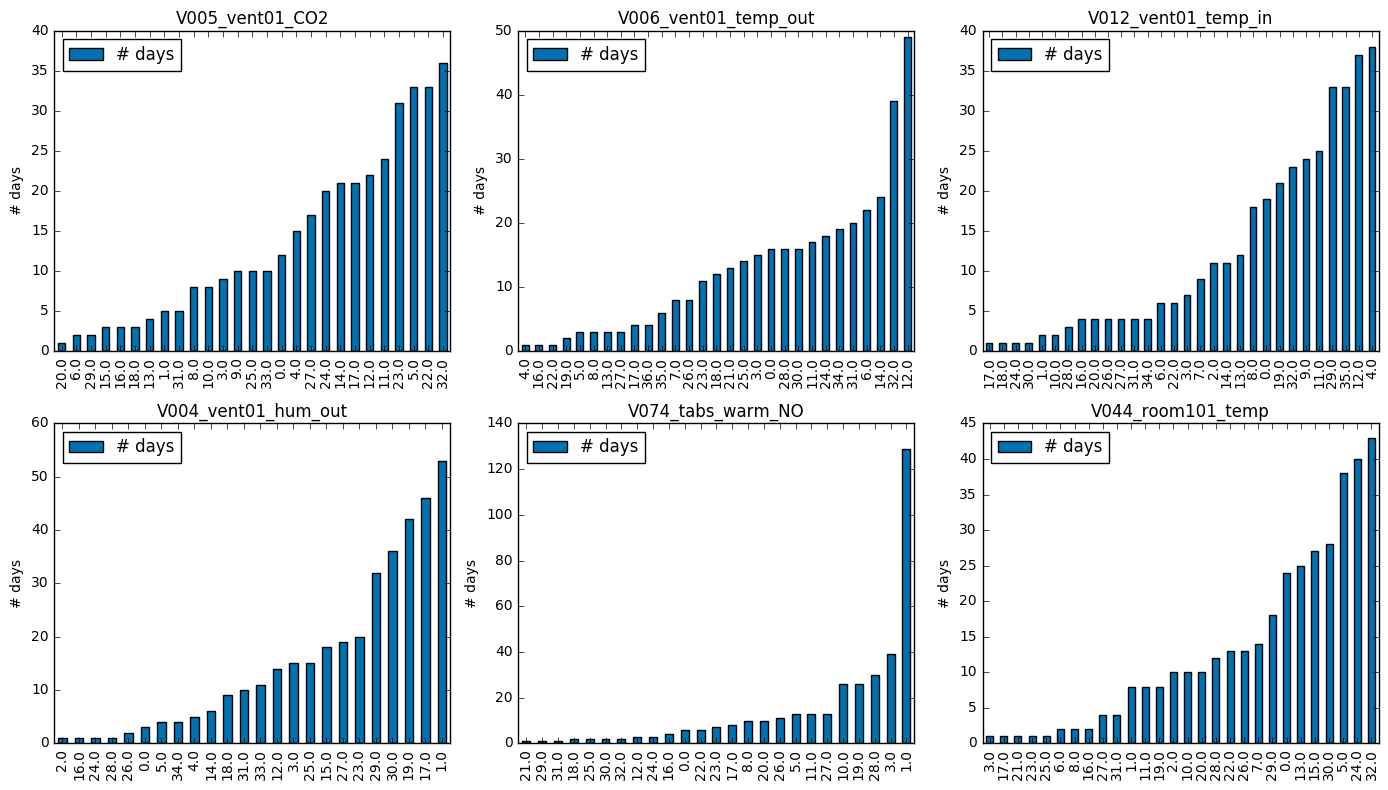

Number of days that are evaluated:  368
DatetimeIndex(['2012-07-02', '2012-07-06', '2012-07-12', '2012-07-20',
               '2012-08-06', '2012-08-30', '2012-08-31', '2012-09-03',
               '2012-09-12', '2012-09-13',
               ...
               '2015-04-02', '2015-04-17', '2015-04-28', '2015-05-04',
               '2015-05-05', '2015-05-15', '2015-05-19', '2015-05-20',
               '2015-05-21', '2015-05-26'],
              dtype='datetime64[ns]', length=368, freq=None)


In [13]:
print('Identifying the most common candidate profiles')
n_col = 3
n_row = int(np.ceil(len(tag_list)/n_col))
fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(14,8))
#print(axes[1])
i,j= 0, 0
list_k = dict()


for tag in tag_list:
    # filter using seasonal_label
    #mask = (df['seasonal_label'] == season) & (df['day_type']==day_type) & (df['interaction_NE']== inter[id_it])
    #mask = (df['seasonal_label'] == season) & (df['day_type']==day_type)
    #mask = (df['day_type']==day_type)

   
    df_filter = df_r
    
    
    #df_filter = df.loc[mask][tag]
    # filter only motif profiles
    #motif_candidates = pack[tag]['motif_candidates']
    if j > n_col-1:
        j=0
        i+=1
    candidates = pack[tag]['motif_candidates'] + pack[tag]['discord_candidates'] 
    df_filter = df_filter[df_filter.isin(candidates)]

    # count the number of days where each motif profile appears 
    r = dict(collections.Counter(df_filter[tag].values))
    list_k[tag] = sorted(r,key=r.get) #list of candidates where the last is the most common
    list_v = [r[d] for d in list_k[tag]]
    df_s = pd.DataFrame([list_v], columns=list_k[tag], index=['# days'])
    df_s.T.plot.bar(ax=axes[i][j])
    axes[i][j].set_title(tag)
    axes[i][j].set_ylabel('# days')
    axes[i][j].legend(loc=2)
    j +=1
plt.tight_layout()
plt.show()
print('Number of days that are evaluated: ', len(df_filter.index))
print(df_filter.index)

In [14]:
tag = tag_list[0]
id_candidates = [22,32]
df_final = df.loc[df_filter[df_filter[tag].isin(id_candidates)].index]
df_final

day_type interaction_NE seasonal_label weekday_name  \
2012-10-24  working_day      Regime NC     t_period_2    Wednesday   
2012-10-25  working_day      Regime NC     t_period_2     Thursday   
2012-10-30  working_day      Regime WC         winter      Tuesday   
2012-11-07  working_day      Regime WC         winter    Wednesday   
2012-11-13  working_day      Regime NC     t_period_2      Tuesday   
2012-11-14  working_day      Regime NC     t_period_2    Wednesday   
2012-11-15  working_day      Regime NC         winter     Thursday   
2012-11-27  working_day      Regime NC         winter      Tuesday   
2012-11-28  working_day      Regime NC         winter    Wednesday   
2012-11-29  working_day      Regime WC         winter     Thursday   
2012-12-18  working_day      Regime NC         winter      Tuesday   
2012-12-19  working_day      Regime NC         winter    Wednesday   
2013-01-08  working_day      Regime NC         winter      Tuesday   
2013-01-11  working_day      Regime NC         winter       Friday   
2013-01-16  working_day      Regime WC         winter    Wednesday   
2013-01-17  working_day      Regime WC         winter     Thursday   
2013-01-24  working_day      Regime NC         winter     Thursday   
2013-01-29  working_day      Regime NC         winter      Tuesday   
2013-02-12  working_day      Regime WC         winter      Tuesday   
2013-02-21  working_day      Regime WC         winter     Thursday   
2013-02-26  working_day      Regime NC         winter      Tuesday   
2013-02-28  working_day      Regime WC         winter     Thursday   
2013-03-01  working_day      Regime WC         winter       Friday   
2013-03-12  working_day      Regime NC     t_period_2      Tuesday   
2013-03-13  working_day      Regime NC         winter    Wednesday   
2013-03-14  working_day      Regime WC         winter     Thursday   
2013-07-03  working_day      Regime NC     t_period_2    Wednesday   
2013-08-08  working_day      Regime NC     t_period_2     Thursday   
2013-10-03  working_day      Regime WC     t_period_2     Thursday   
2013-10-09  working_day      Regime NC     t_period_2    Wednesday   
...                 ...            ...            ...          ...   
2014-10-28  working_day      Regime NC     t_period_2      Tuesday   
2014-11-05  working_day      Regime NC         winter    Wednesday   
2014-11-06  working_day      Regime NC         winter     Thursday   
2014-11-11  working_day      Regime NC         winter      Tuesday   
2014-11-12  working_day      Regime NC         winter    Wednesday   
2014-11-19  working_day      Regime NC     t_period_2    Wednesday   
2014-12-01  working_day      Regime NC         winter       Monday   
2014-12-02  working_day      Regime NC         winter      Tuesday   
2014-12-03  working_day      Regime NC         winter    Wednesday   
2014-12-04  working_day      Regime NC         winter     Thursday   
2014-12-05  working_day      Regime NC         winter       Friday   
2014-12-09  working_day      Regime WC         winter      Tuesday   
2014-12-10  working_day      Regime NC         winter    Wednesday   
2014-12-16  working_day      Regime NC     t_period_2      Tuesday   
2014-12-17  working_day      Regime NC         winter    Wednesday   
2014-12-18  working_day      Regime NC     t_period_2     Thursday   
2015-01-15  working_day      Regime NC         winter     Thursday   
2015-01-21  working_day      Regime WC         winter    Wednesday   
2015-01-22  working_day      Regime NC         winter     Thursday   
2015-01-23  working_day      Regime NC         winter       Friday   
2015-01-27  working_day      Regime WC         winter      Tuesday   
2015-01-28  working_day      Regime NC         winter    Wednesday   
2015-02-03  working_day      Regime WC         winter      Tuesday   
2015-02-04  working_day      Regime NC         winter    Wednesday   
2015-02-05  working_day      Regime NC         winter     Thursday   
2015-02-23  working_day  

In [15]:
result = dict()
for dt in df_final.index:
    xt = dt._date_repr
    result[xt] = df_final.loc[dt][tag]

print(result)
print(df_final.index)

{'2013-02-21': 22, '2014-10-28': 32, '2012-10-30': 22, '2012-11-27': 22, '2014-12-03': 32, '2013-01-11': 22, '2013-03-01': 32, '2015-02-04': 32, '2013-01-29': 22, '2014-02-14': 22, '2015-01-21': 32, '2014-12-17': 32, '2015-01-15': 32, '2012-11-15': 22, '2015-02-25': 32, '2014-02-13': 22, '2013-01-08': 22, '2015-02-05': 22, '2015-01-22': 32, '2014-12-10': 32, '2014-11-12': 32, '2014-11-11': 32, '2013-07-03': 22, '2013-03-12': 22, '2014-12-01': 32, '2014-10-27': 32, '2013-01-24': 22, '2013-10-29': 22, '2013-01-16': 22, '2015-03-05': 32, '2013-10-03': 32, '2013-02-26': 22, '2013-11-05': 22, '2013-03-13': 22, '2014-05-27': 22, '2012-10-24': 22, '2012-11-07': 22, '2013-02-12': 22, '2013-08-08': 32, '2014-12-04': 32, '2013-10-09': 32, '2015-01-28': 32, '2012-11-28': 22, '2014-12-18': 32, '2015-01-23': 32, '2015-03-04': 32, '2012-11-13': 22, '2014-12-16': 32, '2015-01-27': 32, '2014-11-05': 32, '2015-02-03': 32, '2013-02-28': 22, '2015-03-11': 32, '2013-01-17': 22, '2012-11-14': 22, '2015-02-

In [16]:
#filter: Saturday, 
# winter
# profile for V022_vent02_CO2 = 7
# date: ('2012-06-12','2013-12-31')
date_samples1 = ['2012-10-13', '2012-10-27', '2012-11-17', '2012-12-29',
               '2013-01-26', '2013-02-09', '2013-02-23', '2013-03-16',
               '2013-03-23', '2013-04-06', '2013-04-20', '2013-04-27',
               '2013-05-04', '2013-05-25', '2013-06-01', '2013-06-29',
               '2013-09-14', '2013-10-12']

#filter: Saturday, profile for V022_vent02_CO2 = 19
# 'winter', 't_period_2'
# date: ('2014-01-01', '2015-06-08')
date_samples2 = ['2014-01-04', '2014-01-18', '2014-01-25', '2014-02-08',
               '2014-02-22', '2014-03-01', '2014-03-22', '2014-05-03',
               '2014-10-04', '2014-10-11', '2014-10-25', '2014-12-13',
               '2014-12-20', '2015-01-03', '2015-02-07', '2015-02-21',
               '2015-02-28', '2015-03-07', '2015-03-14', '2015-03-21',
               '2015-04-04', '2015-04-25'] 


#filter: working_days, 
# profile for V022_vent02_CO2 = 5
# 'winter', 't_period_2'
# date: ('2012-06-12','2013-12-31')
date_samples3 = ['2012-08-30', '2012-08-31', '2012-10-10', '2012-11-16',
               '2012-11-30', '2013-01-25', '2013-01-30', '2013-02-05',
               '2013-02-06', '2013-02-08', '2013-02-22', '2013-03-15',
               '2013-03-19', '2013-03-20', '2013-03-26', '2013-03-27',
               '2013-03-28', '2013-04-03', '2013-04-11', '2013-05-22',
               '2013-05-24', '2013-05-30', '2013-05-31', '2013-06-27',
               '2013-08-27', '2013-08-28', '2013-09-11', '2013-09-12',
               '2013-09-18', '2013-10-10', '2013-10-11', '2013-10-15'] 

#filter: working_days, 
# profile for V022_vent02_CO2 = 32
# 'winter', 't_period_2'
# date: ('2014-01-01', '2015-06-08')
date_samples4 = ['2014-06-04', '2014-10-13', '2014-10-27', '2014-10-28',
               '2014-11-05', '2014-11-06', '2014-11-11', '2014-11-12',
               '2014-11-19', '2014-12-01', '2014-12-02', '2014-12-03',
               '2014-12-04', '2014-12-05', '2014-12-09', '2014-12-10',
               '2014-12-16', '2014-12-17', '2014-12-18', '2015-01-15',
               '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-27',
               '2015-01-28', '2015-02-03', '2015-02-04', '2015-02-23',
               '2015-02-25', '2015-03-04', '2015-03-05', '2015-03-11'] 


# filter: working_days, (before maintenance period)
# profile for 
# profile for V022_vent02_CO2 = 32 and 22
# 'winter', 't_period_2'
date_samplesx = ['2012-10-24', '2012-10-25', '2012-10-30', '2012-11-07',
               '2012-11-13', '2012-11-14', '2012-11-15', '2012-11-27',
               '2012-11-28', '2012-11-29', '2012-12-18', '2012-12-19',
               '2013-01-08', '2013-01-11', '2013-01-16', '2013-01-17',
               '2013-01-24', '2013-01-29', '2013-02-12', '2013-02-21',
               '2013-02-26', '2013-02-28', '2013-03-01', '2013-03-12',
               '2013-03-13', '2013-03-14', '2013-07-03', '2013-08-08',
               '2013-10-03', '2013-10-09', '2013-10-29', '2013-11-05',
               '2013-11-06', '2014-02-13', '2014-02-14', '2014-05-27',
               '2014-06-04', '2014-10-13', '2014-10-27', '2014-10-28',
               '2014-11-05', '2014-11-06', '2014-11-11', '2014-11-12',
               '2014-11-19', '2014-12-01', '2014-12-02', '2014-12-03',
               '2014-12-04', '2014-12-05', '2014-12-09', '2014-12-10',
               '2014-12-16', '2014-12-17', '2014-12-18', '2015-01-15',
               '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-27',
               '2015-01-28', '2015-02-03', '2015-02-04', '2015-02-05',
               '2015-02-23', '2015-02-25', '2015-03-04', '2015-03-05',
               '2015-03-11']


# filter: working_days, (after maintenance period)
# profile for 
# profile for V022_vent02_CO2 = 12 and 7
# 'winter', 't_period_2'
date_samplesy = ['2012-07-02', '2012-08-30', '2012-10-10', '2012-11-26',
               '2012-12-06', '2012-12-11', '2012-12-12', '2013-01-15',
               '2013-01-17', '2013-07-03', '2013-08-27', '2013-08-28',
               '2013-09-30', '2013-10-07', '2013-10-14', '2013-11-04',
               '2013-11-05', '2013-11-06', '2013-11-19', '2013-11-25',
               '2013-12-02', '2014-01-15', '2014-01-16', '2014-01-21',
               '2014-01-22', '2014-02-10', '2014-03-04', '2014-03-24',
               '2014-05-27', '2014-06-04', '2014-07-02', '2014-07-21',
               '2014-07-30', '2014-08-11', '2014-08-25', '2014-08-26',
               '2014-09-03', '2014-11-11', '2014-11-13', '2014-11-20',
               '2014-11-21', '2014-11-25', '2014-11-28', '2014-12-03',
               '2014-12-04', '2014-12-10', '2014-12-16', '2014-12-17',
               '2014-12-18', '2015-01-14', '2015-01-21', '2015-01-22',
               '2015-01-23', '2015-01-28', '2015-02-03', '2015-02-24',
               '2015-02-27', '2015-03-05', '2015-03-26', '2015-03-31',
               '2015-05-15']

In [17]:
df_x = rs.get_tag_pivoted_values(collection_series, date_samplesx, tag)
X = df_x.values
X1 = X.flatten()

In [18]:
df_x = rs.get_tag_pivoted_values(collection_series, date_samplesy, tag)
X = df_x.values
X2 = X.flatten()

print('X1 mean:', X1.mean())
print('X2 mean:', X2.mean())
print('difference: ', X1.mean() - X2.mean())

X1 mean: 701.891598379
X2 mean: 701.247031365
difference:  0.644567013979


In [19]:
import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

# Use scipy.stats.ttest_ind.
t, p = ttest_ind(X1, X2, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = 0.17523  p = 0.860911


In [20]:
import scipy.stats as st
from collections import namedtuple

TtestResults = namedtuple("Ttest", "T p")
def t_welch(x, y, tails=2):
    """Welch's t-test for two unequal-size samples, not assuming equal variances
    """
    assert tails in (1,2), "invalid: tails must be 1 or 2, found %s"%str(tails)
    x, y = np.asarray(x), np.asarray(y)
    nx, ny = x.size, y.size
    vx, vy = x.var(), y.var()
    df = int((vx/nx + vy/ny)**2 / # Welch-Satterthwaite equation
        ((vx/nx)**2 / (nx - 1) + (vy/ny)**2 / (ny - 1)))
    t_obs = (x.mean() - y.mean()) / np.sqrt(vx/nx + vy/ny)
    p_value = tails * st.t.sf(abs(t_obs), df)
    return t_obs, p_value, df

In [21]:
print(len(X1), len(X2))
t_welch(X1, X2)

1656 1464


(0.17528696672993346, 0.86086609306250794, 2972)

In [22]:
#np.set_printoptions(threshold=np.inf)
#print(X2)

In [23]:
#for dt in df.index:
#    xt = dt._date_repr
#    result[xt] = df.loc[dt][tag]
#print(result)